In [1]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import grayscale2emb
import math
import os
import pandas as pd
import joblib
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Set memory growth to avoid taking all GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

TensorFlow version: 2.18.0
Num GPUs Available:  0
GPU Devices: []


In [2]:
# Define the batch size
batch_size = 64

### Read the data

In [3]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### Encode age labels

In [4]:
# check if the age_encoder is there
if os.path.exists('age_encoder.pkl'):
    age_encoder = joblib.load('age_encoder.pkl')
    print("Age encoder loaded successfully.")
else:
    age_encoder = LabelEncoder()
    
    
    joblib.dump(age_encoder, 'age_encoder.pkl')
    print("Age encoder saved successfully.")
    
train_data['age_label'] = age_encoder.fit_transform(train_data['age'])
val_data['age_label'] = age_encoder.transform(val_data['age'])
test_data['age_label'] = age_encoder.transform(test_data['age'])
num_classes = len(age_encoder.classes_)
print("Age classes:", age_encoder.classes_)

Age encoder loaded successfully.
Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']


### Add image paths

In [5]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)


### Check if images exist

In [6]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

### Filter out any rows where the image doesn't exist

In [7]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Extract image paths and labels

In [8]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['age_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['age_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['age_label'].values

### Define function that process features in batches and store them to avoid recomputation

In [9]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)
    
    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{math.ceil(len(image_paths)/batch_size)}")
        batch_features = grayscale2emb(batch_paths)
        all_features.append(batch_features)
    
    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [10]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_image_paths, 'train_features.npy')
    val_features = preprocess_and_save_features(val_image_paths, 'val_features.npy')
    test_features = preprocess_and_save_features(test_image_paths, 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')


### Standardize features

In [11]:
if os.path.exists('feature_scaler.pkl'):
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")
    
else:
    scaler = StandardScaler()

    # Save the scaler
    joblib.dump(scaler, 'feature_scaler.pkl')

train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

Feature scaler loaded successfully.


### Define a simple softmax model 

In [12]:
model = Sequential([
    Dense(num_classes, activation='softmax', input_shape=(train_features.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,392 (64.03 KB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [13]:
print("Training the model...")
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

# Define the early stopping callback before training the model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=5,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)


# Then in model.fit:
history = model.fit(
    train_features_scaled, train_labels,
    validation_data=(val_features_scaled, val_labels),
    epochs=30,
    batch_size=batch_size,
    class_weight=class_weight_dict,
     callbacks=[early_stopping]
)

Training the model...
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3293 - loss: 1.8560 - val_accuracy: 0.4804 - val_loss: 1.4048
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5441 - loss: 1.1217 - val_accuracy: 0.5240 - val_loss: 1.2706
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6165 - loss: 0.9400 - val_accuracy: 0.5543 - val_loss: 1.2320
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6618 - loss: 0.8540 - val_accuracy: 0.5472 - val_loss: 1.2368
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6881 - loss: 0.7760 - val_accuracy: 0.5658 - val_loss: 1.2086
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7019 - loss: 0.7300 - val_accuracy: 0.5783 - val_loss: 1.1976
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7210 - loss: 0.6976 - val_accuracy: 0.5688 - val_loss: 1.1999
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7322 - loss: 0.6

### Save the model

In [14]:
model.save('softmax_age_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


### Evaluate the model

In [15]:
print("Evaluating the model on test data...")
test_loss, test_acc = model.evaluate(test_features_scaled, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating the model on test data...
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4047 - loss: 1.8021
Test Loss: 1.9424
Test Accuracy: 0.3779


### Get predictions

In [16]:
test_predictions = model.predict(test_features_scaled)
test_pred_classes = np.argmax(test_predictions, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Visualize results

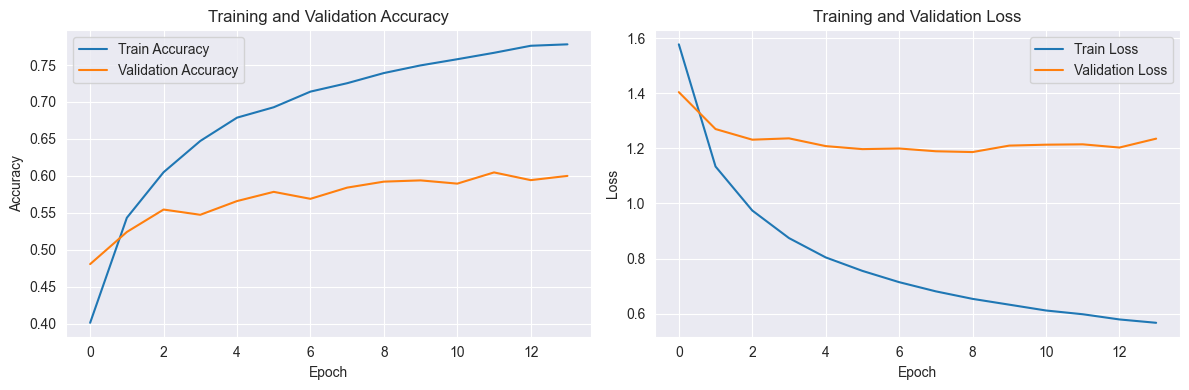

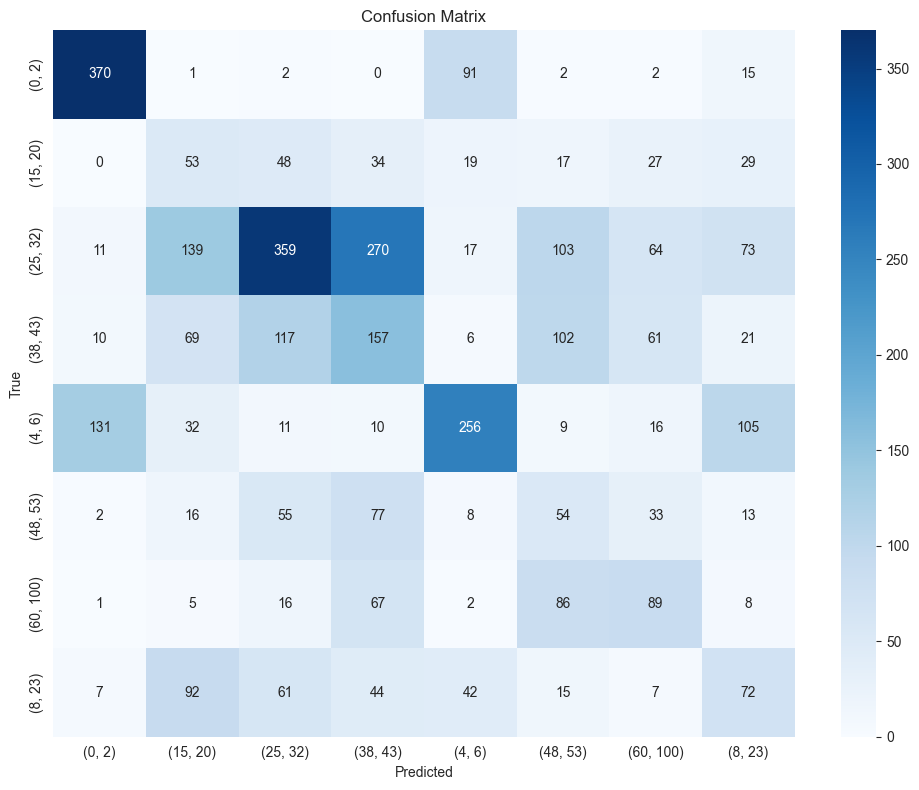

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=age_encoder.classes_,
            yticklabels=age_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Classification report

In [18]:
print("Classification Report:")
print(classification_report(test_labels, test_pred_classes, target_names=age_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.70      0.77      0.73       483
    (15, 20)       0.13      0.23      0.17       227
    (25, 32)       0.54      0.35      0.42      1036
    (38, 43)       0.24      0.29      0.26       543
      (4, 6)       0.58      0.45      0.51       570
    (48, 53)       0.14      0.21      0.17       258
   (60, 100)       0.30      0.32      0.31       274
     (8, 23)       0.21      0.21      0.21       340

    accuracy                           0.38      3731
   macro avg       0.35      0.35      0.35      3731
weighted avg       0.42      0.38      0.39      3731


### Example of using the model

Model loaded successfully.
Age encoder loaded successfully.
Feature scaler loaded successfully.
Using sample image: ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg
Extracting features from ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg...
Standardizing features...
Making prediction...
Predicted age range: (0, 2) with confidence 0.37


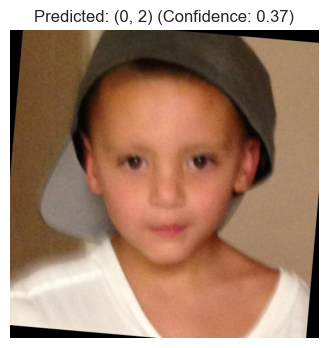


Code for making predictions on new images:


In [19]:
# Load the trained model
model = tf.keras.models.load_model('softmax_age_classifier.h5')
print("Model loaded successfully.")

# Load the LabelEncoder
age_encoder = joblib.load('age_encoder.pkl')
print("Age encoder loaded successfully.")

# Load the scaler
scaler = joblib.load('feature_scaler.pkl')
print("Feature scaler loaded successfully.")

def predict_age(image_path, model, age_encoder, scaler):
    """
    Predict the age range for a given face image.
    
    Parameters:
    image_path (str): Path to the image file
    model: Trained Keras model
    age_encoder: Trained LabelEncoder for age classes
    scaler: Trained StandardScaler for feature normalization
    
    Returns:
    tuple: (predicted_age_range, confidence)
    """
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"Error: File {image_path} not found")
        return None, 0
        
    # Extract features
    print(f"Extracting features from {image_path}...")
    features = grayscale2emb([image_path])
    
    # Check if feature extraction was successful
    if features.size == 0:
        print("Error: Feature extraction failed")
        return None, 0
        
    # Standardize features
    print("Standardizing features...")
    features_scaled = scaler.transform(features)
    
    # Make prediction
    print("Making prediction...")
    pred_probs = model.predict(features_scaled, verbose=0)[0]
    
    # Get predicted class
    pred_class = np.argmax(pred_probs)
    
    # Convert to age range
    pred_age_range = age_encoder.classes_[pred_class]
    confidence = pred_probs[pred_class]

    return pred_age_range, confidence

# Example usage with a sample image
# Replace with an actual path to test
sample_image_path = test_image_paths[0]  # Using the first test image as an example
print(f"Using sample image: {sample_image_path}")

# Make prediction
pred_age, confidence = predict_age(sample_image_path, model, age_encoder, scaler)

if pred_age is not None:
    print(f"Predicted age range: {pred_age} with confidence {confidence:.2f}")
    
    # Display the image if possible
    try:
        from PIL import Image
        img = Image.open(sample_image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_age} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

print("\nCode for making predictions on new images:")